## Household Power Consumption Forecasting
## (Supplementary Notebook)

General Note: For uniformity and reusability, most of the following Notes and Codes were copied from the previous module on Temperature Forecasting (Supplementary Notebook) and were modified only as needed.
<br>
<br>
The Household Power Consumption Dataset can be downloaded from Kaggle website through the following URL link:
<br>
https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set?select=household_power_consumption.txt
   

This supplementary notebook applies the methodology used in the M5 Forecasting notebook to the Household Power Consumption dataset. In tis supplementary notebook, we will be forecasting the household daily power consumption.
<br>
<br>
This supplementary notebook was prepared by Leo R. De Velez

### 1. Household Power Consumption (Daily) Dataset

Read the previously downloaded Household Power Consumption dataset and examine it.

In [1]:
##
## The following codes were copied from Temperature Forecasting (Supplementary Notebook)
## and modified only as needed.
##

import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### CREATE X,Y ####
def create_xy(series, window_size, prediction_horizon, shuffle = False):
    x = []
    y = []
    for i in range(0, len(series)):
        if len(series[(i + window_size):(i + window_size + prediction_horizon)]) < prediction_horizon:
            break
        x.append(series[i:(i + window_size)])
        y.append(series[(i + window_size):(i + window_size + prediction_horizon)])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [2]:
##
## This is an abbreviated version of Marwell Dalangin's data processing code
## and were modified only as needed.
##
## Download the data from
## https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set?select=household_power_consumption.txt
##

data_source = 'data/household_power_consumption.txt.zip'
df = pd.read_csv(data_source,
     sep=';',
     parse_dates={'dt': ['Date', 'Time']},
     infer_datetime_format=True,
     low_memory=False,
     na_values=['nan', '?'],
     index_col='dt')
df.columns = [x.lower() for x in df.columns]
# features
relevant_columns = [
    "global_active_power", "global_reactive_power", "voltage",
    "global_intensity", "sub_metering_1", "sub_metering_2",
    "sub_metering_3"
    ]
# Handling missing values
for every_column in relevant_columns:
    df[every_column] = df[every_column].interpolate()
# Computation for overall power consumtion
eq1 = (df['global_active_power'] * 1000 / 60)
eq2 = df['sub_metering_1'] + \
    df['sub_metering_2'] + df['sub_metering_3']
df['power_consumption'] = eq1 - eq2
relevant_columns = df.columns
# Aggregating level: "M" - Monthly, "W" - Weekly, "D" - Daily, "H" - Hourly
df = df[relevant_columns].resample("D").sum()
df = df['power_consumption']

<bound method NDFrame.head of             power_consumption
dt                           
2006-12-16       14680.933333
2006-12-17       36946.666667
2006-12-18       19028.433333
2006-12-19       13131.900000
2006-12-20       20384.800000
...                       ...
2010-11-22       16924.600000
2010-11-23       16352.266667
2010-11-24       13769.466667
2010-11-25       17278.733333
2010-11-26       13347.733333

[1442 rows x 1 columns]>
DatetimeIndex(['2006-12-16', '2006-12-17', '2006-12-18', '2006-12-19',
               '2006-12-20', '2006-12-21', '2006-12-22', '2006-12-23',
               '2006-12-24', '2006-12-25',
               ...
               '2010-11-17', '2010-11-18', '2010-11-19', '2010-11-20',
               '2010-11-21', '2010-11-22', '2010-11-23', '2010-11-24',
               '2010-11-25', '2010-11-26'],
              dtype='datetime64[ns]', name='dt', length=1442, freq='D')


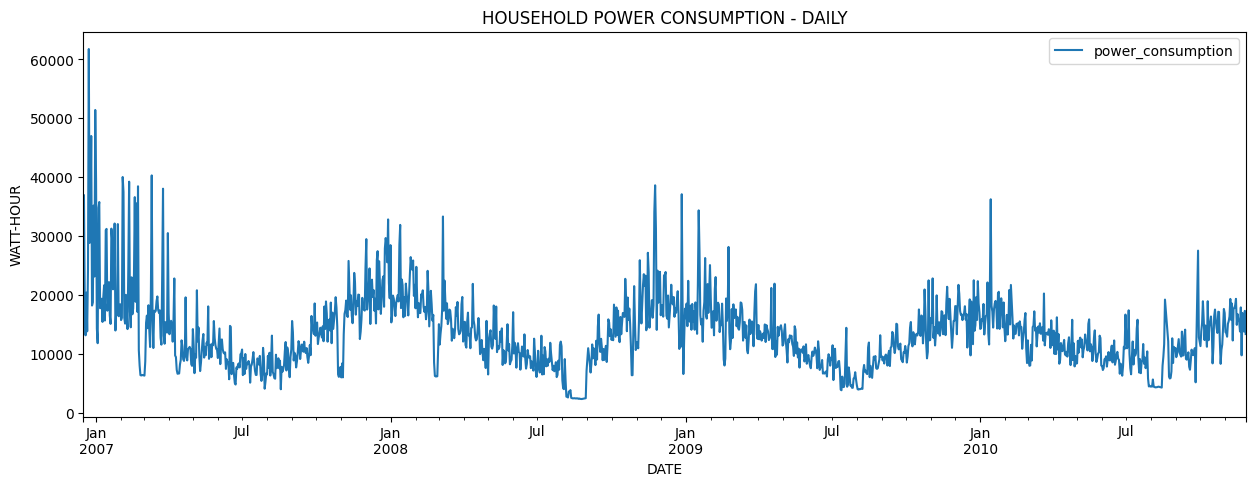

In [3]:
##
## The following codes were copied from Temperature Forecasting (Supplementary Notebook)
## and modified only as needed.
##

series = pd.DataFrame(df)
print(series.head)
print(series.index)

plt.rcParams['figure.figsize'] = [15, 5]
#np.set_printoptions(precision = 6, suppress = True)
series.plot()
plt.title("HOUSEHOLD POWER CONSUMPTION - DAILY")
plt.xlabel("DATE")
plt.ylabel("WATT-HOUR")
plt.legend()
plt.show()

In [4]:
##
## The following codes were copied from Temperature Forecasting (Supplementary Notebook)
## and modified only as needed.
##

### HYPERPARAMETERS ###
window_size = 30
prediction_horizon = 1
### TRAIN VAL SPLIT ###
train_series = series.iloc[:1010, 0]
val_series = series.iloc[1010:1298, 0]
test_series = series.iloc[1298:, 0]
train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
val_x, val_y = create_xy(val_series.to_numpy(), window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)
train_y = train_y.flatten()
val_y = val_y.flatten()
test_y = test_y.flatten()
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(test_x.shape)
print(test_y.shape)

(980, 30)
(980,)
(258, 30)
(258,)
(114, 30)
(114,)


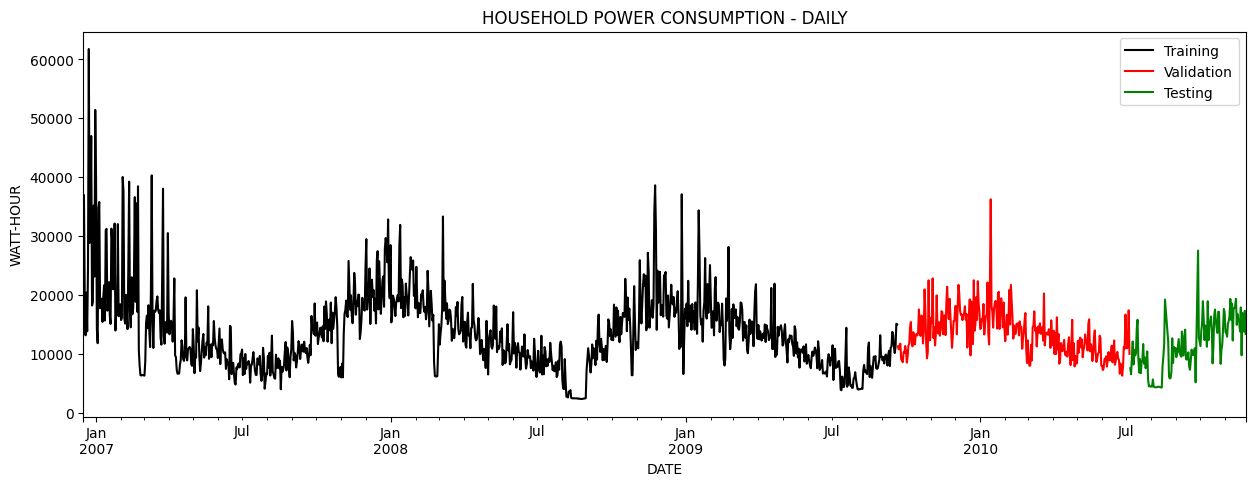

In [5]:
## Show the split of data from training, validation, and testing.

train_series.plot(color='black', label='Training')
val_series.plot(color='red', label = 'Validation')
test_series.plot(color='green', label = 'Testing')
plt.title("HOUSEHOLD POWER CONSUMPTION - DAILY")
plt.xlabel("DATE")
plt.ylabel("WATT-HOUR")
plt.legend()
plt.show()

### 2. Setup the LightGBM Model

Setup the LightGBM model.

In [6]:
##
## The following codes were copied from Temperature Forecasting (Supplementary Notebook)
## and modified only as needed.
##

import lightgbm as lgb

model = lgb.LGBMRegressor()

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(val_x, val_y)],
          early_stopping_rounds = 100,
          verbose = 0)

LGBMRegressor()

In [7]:
## Check the forecasting accuracy of LightGBM

forecast = model.predict(test_x)
print('  LightGBM MAE  : %.4f' % (np.mean(np.abs(forecast - test_y))))
print('  LightGBM MAPE : %.4f' % (np.mean(np.abs(forecast - test_y)/test_y*100)))
print('  LightGBM RMSE : %.4f' % (np.sqrt(np.mean((forecast - test_y)**2))))

  LightGBM MAE  : 2364.4686
  LightGBM MAPE : 22.6158
  LightGBM RMSE : 3202.1206


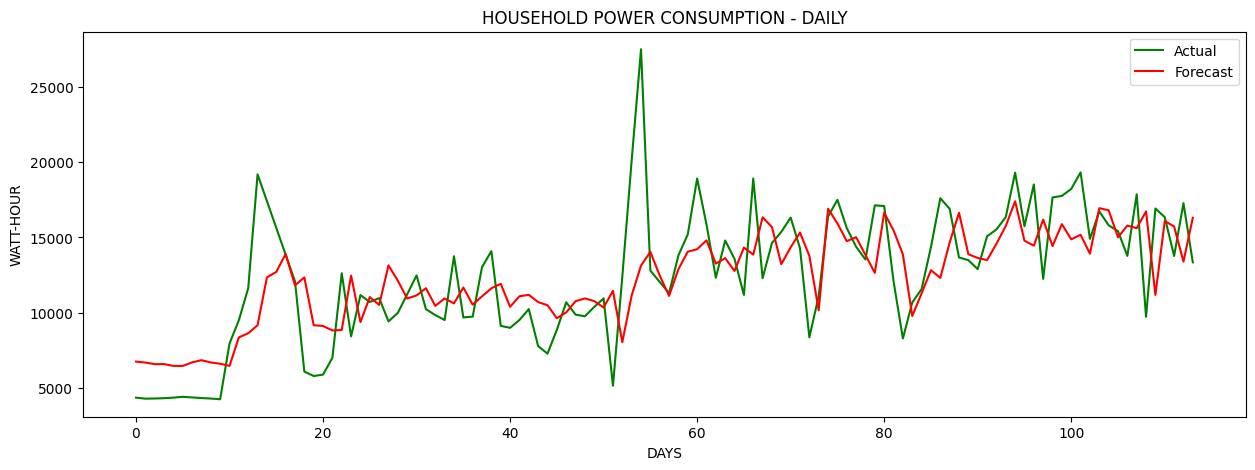

In [8]:
## Graphically compare the forecast vs actual data.
##

plt.plot(test_y, color='green', label = 'Actual')
plt.plot(forecast, color='red', label = 'Forecast')
plt.title("HOUSEHOLD POWER CONSUMPTION - DAILY")
plt.xlabel("DAYS")
plt.ylabel("WATT-HOUR")
plt.legend()
plt.show()

### 3. Tune the LightGBM Hyperparameters

Determine the best window setting for the LightGBM model.

  7 --- MAE: -3072.994 (323.064)
 14 --- MAE: -2940.047 (292.854)
 21 --- MAE: -2788.392 (259.550)
 30 --- MAE: -2761.929 (360.240)
 45 --- MAE: -2671.581 (200.908)
 90 --- MAE: -2393.212 (291.955)
180 --- MAE: -2356.369 (217.123)
365 --- MAE: -2399.564 (286.079)


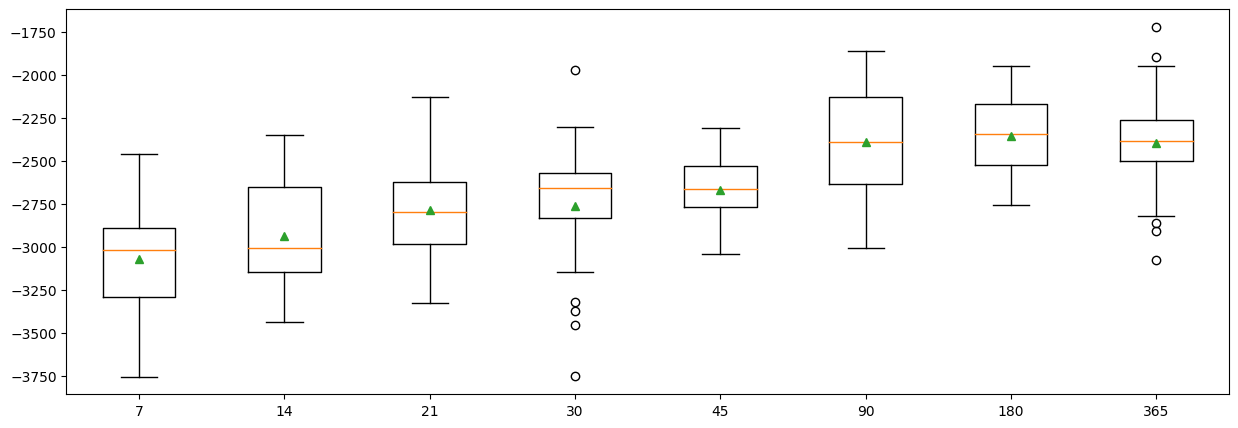

In [9]:
##
## The following codes were copied from this Time Series Workbook, Chapter 8, 
## lightgbm_m5_forecasting.ipynb
## and modified only as needed.
##

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

params = {
    'n_estimators': 1000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}
windows = [7, 14, 21, 30, 45, 90, 180, 365]
results = []
names = []
for w in windows:
    window_size = w
    train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
    train_y = train_y.flatten()
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 123)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(w)
    print('%3d --- MAE: %.3f (%.3f)' % (w, np.mean(scores), np.std(scores)))

plt.rcParams['figure.figsize'] = [15, 5]    
plt.boxplot(results, labels = names, showmeans = True)
plt.show()

Use the window size that produced the lowest Mean Absolute Error. Compare the resulting MAE, MAPE, and RMSE.

In [10]:
##
## The following codes were copied from Temperature Forecasting (Supplementary Notebook)
## and modified only as needed.
##

### HYPERPARAMETERS ###
window_size = 45 
prediction_horizon = 1
### TRAIN VAL SPLIT ###
train_series = series.iloc[:1010, 0]
val_series = series.iloc[1010:1298, 0]
test_series = series.iloc[1298:, 0]
train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
val_x, val_y = create_xy(val_series.to_numpy(), window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)
train_y = train_y.flatten()
val_y = val_y.flatten()
test_y = test_y.flatten()
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(test_x.shape)
print(test_y.shape)

(965, 45)
(965,)
(243, 45)
(243,)
(99, 45)
(99,)


In [28]:
params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          verbose = 0)

forecast = model.predict(test_x)

new_series = pd.DataFrame(test_series)
s1_naive = new_series[-29:-1].to_numpy()
s7_naive = new_series[-35:-7].to_numpy()
s30_naive = new_series[-56:-28].to_numpy()
#s365_naive = new_series[-364:-336].to_numpy()

print('     Naive MAE: %.4f' % (np.mean(np.abs(s1_naive - test_y))))
print('  s7-Naive MAE: %.4f' % (np.mean(np.abs(s7_naive - test_y))))
print(' s30-Naive MAE: %.4f' % (np.mean(np.abs(s30_naive - test_y))))
#print('s365-Naive MAE: %.4f' % (np.mean(np.abs(s365_naive - test_y))))
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast - test_y))))

print('     Naive MAPE: %.4f' % (np.mean(np.abs(s1_naive - test_y)/test_y*100)))
print('  s7-Naive MAPE: %.4f' % (np.mean(np.abs(s7_naive - test_y)/test_y*100)))
print(' s30-Naive MAPE: %.4f' % (np.mean(np.abs(s30_naive - test_y)/test_y*100)))
#print('s365-Naive MAPE: %.4f' % (np.mean(np.abs(s365_naive - test_y)/test_y*100)))
print('  LightGBM MAPE: %.4f' % (np.mean(np.abs(forecast - test_y)/test_y*100)))


     Naive MAE: 4122.0507
  s7-Naive MAE: 4086.5685
 s30-Naive MAE: 3793.6837
  LightGBM MAE: 2476.1981
     Naive MAPE: 39.7419
  s7-Naive MAPE: 38.5235
 s30-Naive MAPE: 34.3352
  LightGBM MAPE: 19.4638


In [15]:
## Re-Run the prediction model and check the resulting forecasting accuracy

forecast = model.predict(test_x)
print('  LightGBM MAE  : %.4f' % (np.mean(np.abs(forecast - test_y))))
print('  LightGBM MAPE : %.4f' % (np.mean(np.abs(forecast - test_y)/test_y*100)))
print('  LightGBM RMSE : %.4f' % (np.sqrt(np.mean((forecast - test_y)**2))))

  LightGBM MAE  : 2440.8520
  LightGBM MAPE : 20.5251
  LightGBM RMSE : 3376.1500


The LightRBM Mean Absolute Percent Error improved from 22.6% down to 19.6%.

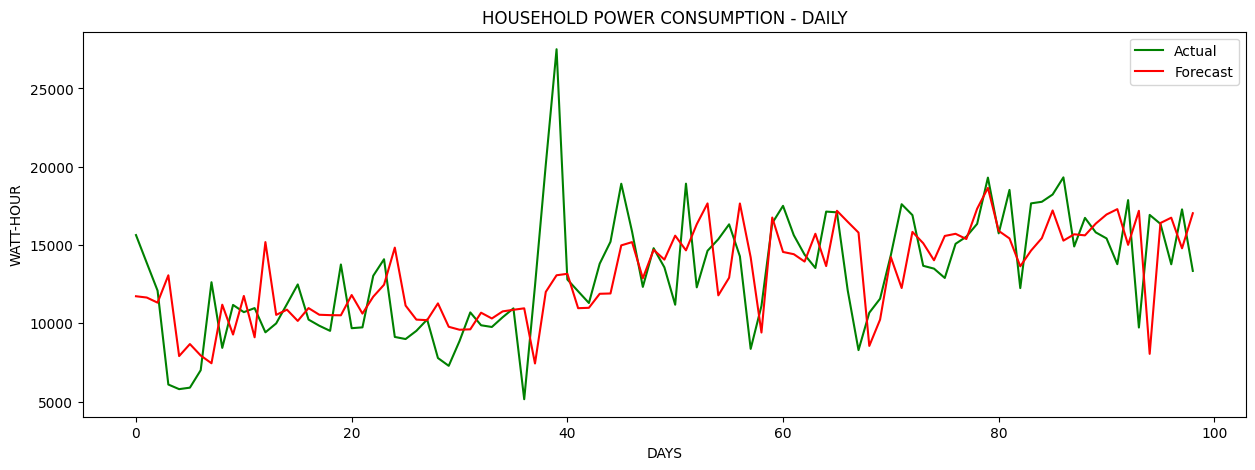

In [16]:
## Graphically compare the forecast vs actual data.
##

plt.plot(test_y, color='green', label = 'Actual')
plt.plot(forecast, color='red', label = 'Forecast')
plt.title("HOUSEHOLD POWER CONSUMPTION - DAILY")
plt.xlabel("DAYS")
plt.ylabel("WATT-HOUR")
plt.legend()
plt.show()

### 4. Recursive LightGBM Forecasting

In [17]:
##
## The following codes were copied from Temperature Forecasting (Supplementary Notebook)
## and modified only as needed.
##

recursive_x = test_x
forecast_ms = []
for j in range(prediction_horizon):
    pred = model.predict(recursive_x)
    recursive_x = np.hstack((recursive_x[:, 1:], pred[:, np.newaxis]))
    forecast_ms.append(pred)
forecast_ms = np.asarray(forecast_ms).T
print('LightGBM')
print('MAE  :', np.mean(np.abs(test_y - forecast_ms)))
print('MAPE :', np.mean(np.abs(test_y - forecast_ms)/test_y*100))
print('RMSE :', np.sqrt(np.mean((test_y - forecast_ms)**2)))
print('')

LightGBM
MAE  : 3758.8436710463275
MAPE : 32.28177860409653
RMSE : 4704.980644436608



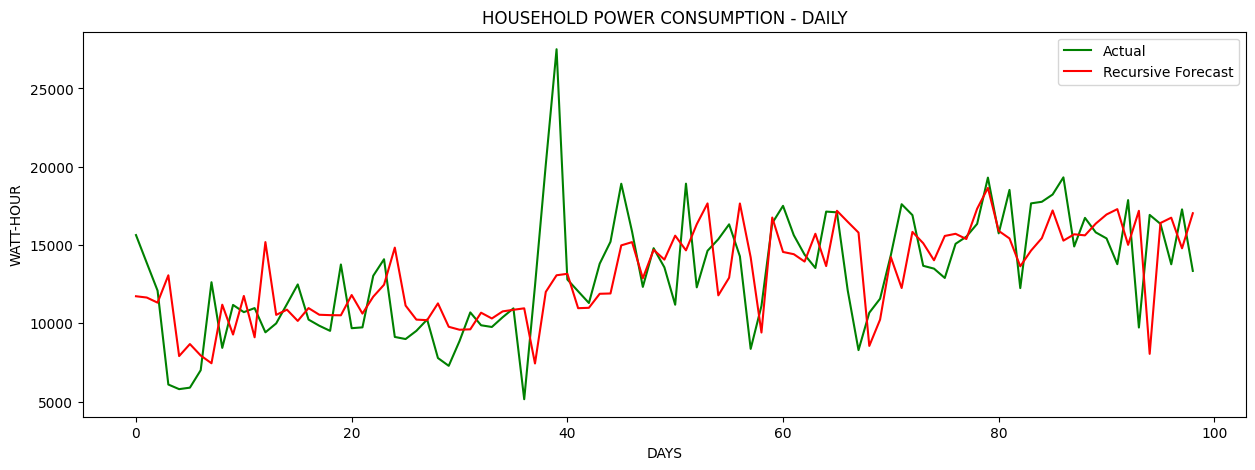

In [18]:
## Graphically compare the recursive forecast vs actual data.
##

plt.plot(test_y, color='green', label = 'Actual')
plt.plot(forecast_ms, color='red', label = 'Recursive Forecast')
plt.title("HOUSEHOLD POWER CONSUMPTION - DAILY")
plt.xlabel("DAYS")
plt.ylabel("WATT-HOUR")
plt.legend()
plt.show()

### 5. Compare LightGBM with Naive and sNaive benchmarks

In [19]:
new_series = pd.DataFrame(test_series)
s1_naive = new_series[-29:-1].to_numpy()
s7_naive = new_series[-35:-7].to_numpy()
s30_naive = new_series[-56:-28].to_numpy()
#s365_naive = new_series[-364:-336].to_numpy()

print('     Naive MAE: %.4f' % (np.mean(np.abs(s1_naive - test_y))))
print('  s7-Naive MAE: %.4f' % (np.mean(np.abs(s7_naive - test_y))))
print(' s30-Naive MAE: %.4f' % (np.mean(np.abs(s30_naive - test_y))))
#print('s365-Naive MAE: %.4f' % (np.mean(np.abs(s365_naive - test_y))))
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast_ms - test_y))))

print('     Naive MAPE: %.4f' % (np.mean(np.abs(s1_naive - test_y)/test_y*100)))
print('  s7-Naive MAPE: %.4f' % (np.mean(np.abs(s7_naive - test_y)/test_y*100)))
print(' s30-Naive MAPE: %.4f' % (np.mean(np.abs(s30_naive - test_y)/test_y*100)))
#print('s365-Naive MAPE: %.4f' % (np.mean(np.abs(s365_naive - test_y)/test_y*100)))
print('  LightGBM MAPE: %.4f' % (np.mean(np.abs(forecast_ms - test_y)/test_y*100)))

     Naive MAE: 4122.0507
  s7-Naive MAE: 4086.5685
 s30-Naive MAE: 3793.6837
  LightGBM MAE: 3758.8437
     Naive MAPE: 39.7419
  s7-Naive MAPE: 38.5235
 s30-Naive MAPE: 34.3352
  LightGBM MAPE: 32.2818


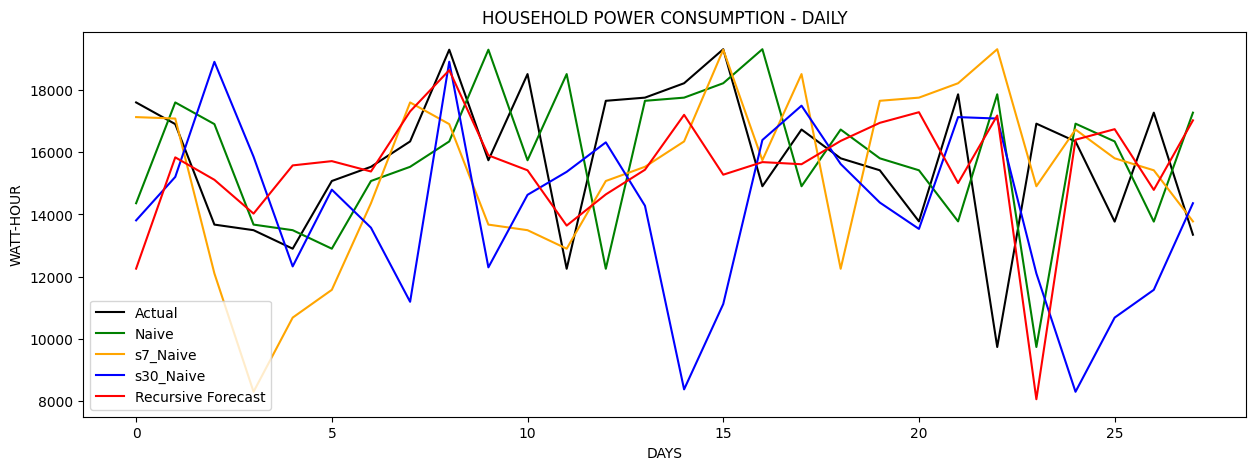

In [20]:
## Graphically compare the recursive forecast vs benchmarks
##
plt.plot(test_y[-28:], color='black', label = 'Actual')
plt.plot(s1_naive, color='green', label = 'Naive')
plt.plot(s7_naive, color='orange', label = 's7_Naive')
plt.plot(s30_naive, color='blue', label = 's30_Naive')
plt.plot(forecast_ms[-28:], color='red', label = 'Recursive Forecast')
plt.title("HOUSEHOLD POWER CONSUMPTION - DAILY")
plt.xlabel("DAYS")
plt.ylabel("WATT-HOUR")
plt.legend()
plt.show()

### 6. Using Hourly and Weekly Household Power Consumption Data

In [29]:
data_source = 'data/household_power_consumption.txt.zip'
df = pd.read_csv(data_source,
     sep=';',
     parse_dates={'dt': ['Date', 'Time']},
     infer_datetime_format=True,
     low_memory=False,
     na_values=['nan', '?'],
     index_col='dt')
df.columns = [x.lower() for x in df.columns]
# features
relevant_columns = [
    "global_active_power", "global_reactive_power", "voltage",
    "global_intensity", "sub_metering_1", "sub_metering_2",
    "sub_metering_3"
    ]
# Handling missing values
for every_column in relevant_columns:
    df[every_column] = df[every_column].interpolate()
# Computation for overall power consumtion
eq1 = (df['global_active_power'] * 1000 / 60)
eq2 = df['sub_metering_1'] + \
    df['sub_metering_2'] + df['sub_metering_3']
df['power_consumption'] = eq1 - eq2
relevant_columns = df.columns
# Aggregating level: "M" - Monthly, "W" - Weekly, "D" - Daily, "H" - Hourly
df = df[relevant_columns].resample("W").sum()
df = df['power_consumption']
print(df.head)

<bound method NDFrame.head of dt
2006-12-17     51627.600000
2006-12-24    181305.633333
2006-12-31    224900.200000
2007-01-07    171702.133333
2007-01-14    153877.616667
                  ...      
2010-10-31     91516.866667
2010-11-07    106334.966667
2010-11-14    119489.866667
2010-11-21    104251.833333
2010-11-28     77672.800000
Freq: W-SUN, Name: power_consumption, Length: 207, dtype: float64>


In [30]:
series = pd.DataFrame(df)

### HYPERPARAMETERS ###
window_size = 7 
prediction_horizon = 1
### TRAIN VAL SPLIT ###
train_series = series.iloc[:167, 0]
val_series = series.iloc[167:187, 0]
test_series = series.iloc[187:, 0]
train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
val_x, val_y = create_xy(val_series.to_numpy(), window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)
train_y = train_y.flatten()
val_y = val_y.flatten()
test_y = test_y.flatten()

In [31]:
model = lgb.LGBMRegressor()
model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(val_x, val_y)],
          early_stopping_rounds = 100,
          verbose = 0)

LGBMRegressor()

In [32]:
forecast = model.predict(test_x)
print('  LightGBM MAE  : %.4f' % (np.mean(np.abs(forecast - test_y))))
print('  LightGBM MAPE : %.4f' % (np.mean(np.abs(forecast - test_y)/test_y*100)))
print('  LightGBM RMSE : %.4f' % (np.sqrt(np.mean((forecast - test_y)**2))))

  LightGBM MAE  : 15166.6247
  LightGBM MAPE : 16.7155
  LightGBM RMSE : 18252.3583


### 7. Summary

The forecasting accuracy of the LightGBM for the household power consumption was better than the Naive and sNaive benchmarks.  However, the LightGBM is still on the low side with a Mean Absolute Precentage Error of around 20%.  
The fine tuning of the model helped improve the accuracy by only a bit, from 22% MAPE to 19%.
There were only 1,442 daily data points that was used for training, validation, and testing.  The number of data points was on the low side for LightGBM.  Using the Hourly Household Power Consumpition did not improve the LightGBM accuracy.  However, when weekly household power consumption was used, even with fewer data to use, the LightGBM forecasting accuracy improved to below 17% Mean Absolute Percentage Error.